<a href="https://colab.research.google.com/github/GisellyOliveira/Sprint3-MVP/blob/main/MVP_Previs%C3%A3o_pre%C3%A7o_industrial_do_cobre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import pickle
import numpy as np
from scipy.stats import skew
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


EXTRAÇÃO DE DADOS

In [ ]:
url = "https://raw.githubusercontent.com/GisellyOliveira/datasets/refs/heads/main/Copper_Set.csv"
df = pd.read_csv(url, low_memory=False)
df.head(2)


,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,20210401.0,54.15113862,30156308.0,28.0,Won,W,10.0,2.0,1500.0,DEQ1 S460MC,1670798778,20210701.0,854.0
1,4E5F4B3D-DDDF-499D-AFDE-A3227EC49425,20210401.0,768.0248392,30202938.0,25.0,Won,W,41.0,0.8,1210.0,0000000000000000000000000000000000104991,1668701718,20210401.0,1047.0


LIMPEZA DOS DADOS

In [ ]:
df.shape

(181673, 14)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181673 entries, 0 to 181672
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             181671 non-null  object 
 1   item_date      181672 non-null  float64
 2   quantity tons  181673 non-null  object 
 3   customer       181672 non-null  float64
 4   country        181645 non-null  float64
 5   status         181671 non-null  object 
 6   item type      181673 non-null  object 
 7   application    181649 non-null  float64
 8   thickness      181672 non-null  float64
 9   width          181673 non-null  float64
 10  material_ref   103754 non-null  object 
 11  product_ref    181673 non-null  int64  
 12  delivery date  181672 non-null  float64
 13  selling_price  181672 non-null  float64
dtypes: float64(8), int64(1), object(5)
memory usage: 19.4+ MB


In [ ]:
# Substituindo valores de 'material_ref' que começam com '00000' por 'unknown'
df.loc[df['material_ref'].str.startswith('00000', na=False), 'material_ref'] = 'unknown'

# 'material_ref' possui um grande conjunto de valores nulos, então substituindo-os por 'unknown'
df['material_ref'] = df['material_ref'].fillna('unknown')

# Substituindo um valor não numérico em 'quantity tons' por np.nan
df.loc[df['quantity tons'].str.contains('^e', na=False),'quantity tons'] = np.nan

In [ ]:
# Conversão de tipo de dados de algumas colunas
df = df.astype({'quantity tons':'float64'})
df['item_date'] = pd.to_datetime(df['item_date'],format='%Y%m%d', errors='coerce').dt.date
df['delivery date'] = pd.to_datetime(df['delivery date'],format='%Y%m%d', errors='coerce').dt.date

In [ ]:
df.isna().sum()

,0
id,2
item_date,3
quantity tons,1
customer,1
country,28
status,2
item type,0
application,24
thickness,1
width,0


In [ ]:
# Excluindo os valores nulos restantes, pois representam menos de 1% dos dados, o que pode ser negligenciado
df = df.dropna()

PRÉ-PROCESSAMENTO DE DADOS

Estimando a assimetria das variáveis contínuas

In [ ]:
# Assimetria das características
print('Assimetria de:','\n')
print('Quantidade:', skew(df['quantity tons']))
print('Espessura:', skew(df['thickness']))
print('Largura:', skew(df['width']))
print('Preço de Venda:', skew(df['selling_price']))

Assimetria de: 

Quantidade: 424.63821570967093
Espessura: 303.46908538522666
Largura: 0.37484155989536533
Preço de Venda: 301.35075873520265


As características Quantidade, Espessura e Preço de venda apresentam uma forte assimetria. Vamos visualizar a assimetria.

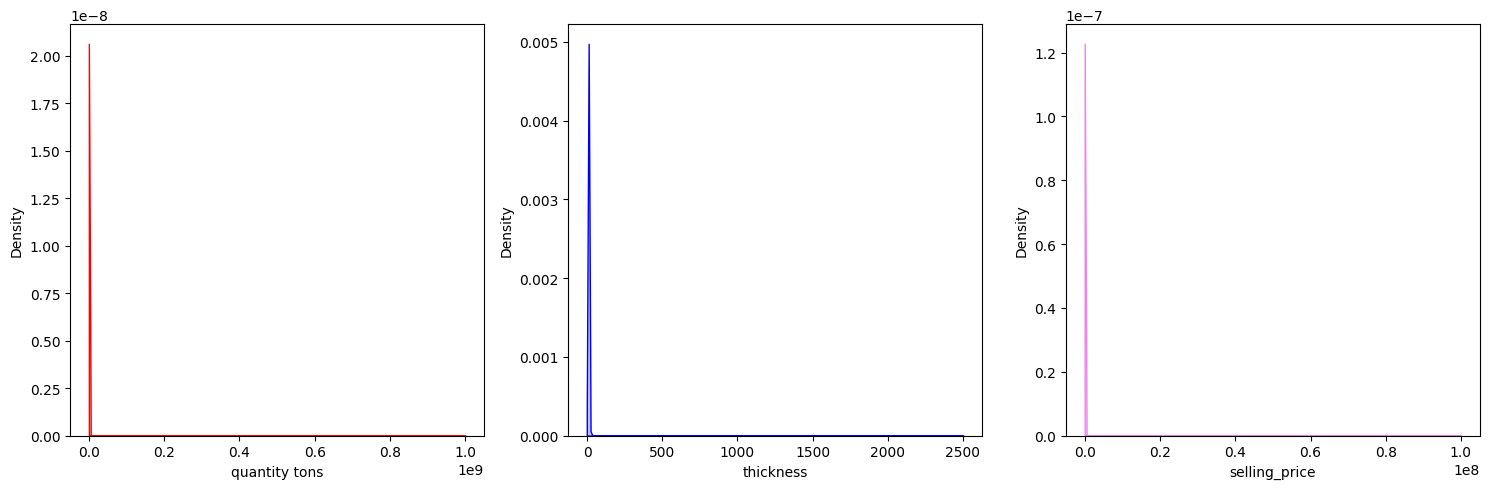

In [ ]:
# Gráfico de Densidade do Kernel
plt.figure(figsize=(15, 5))
plt.title("Gráfico de Densidade do Kernel")

plt.subplot(131)
sns.kdeplot(df['quantity tons'], color='red', fill=True)

plt.subplot(132)
sns.kdeplot(df['thickness'], color='blue', fill=True)

plt.subplot(133)
sns.kdeplot(df['selling_price'], color='violet', fill=True)

plt.tight_layout()
plt.show()

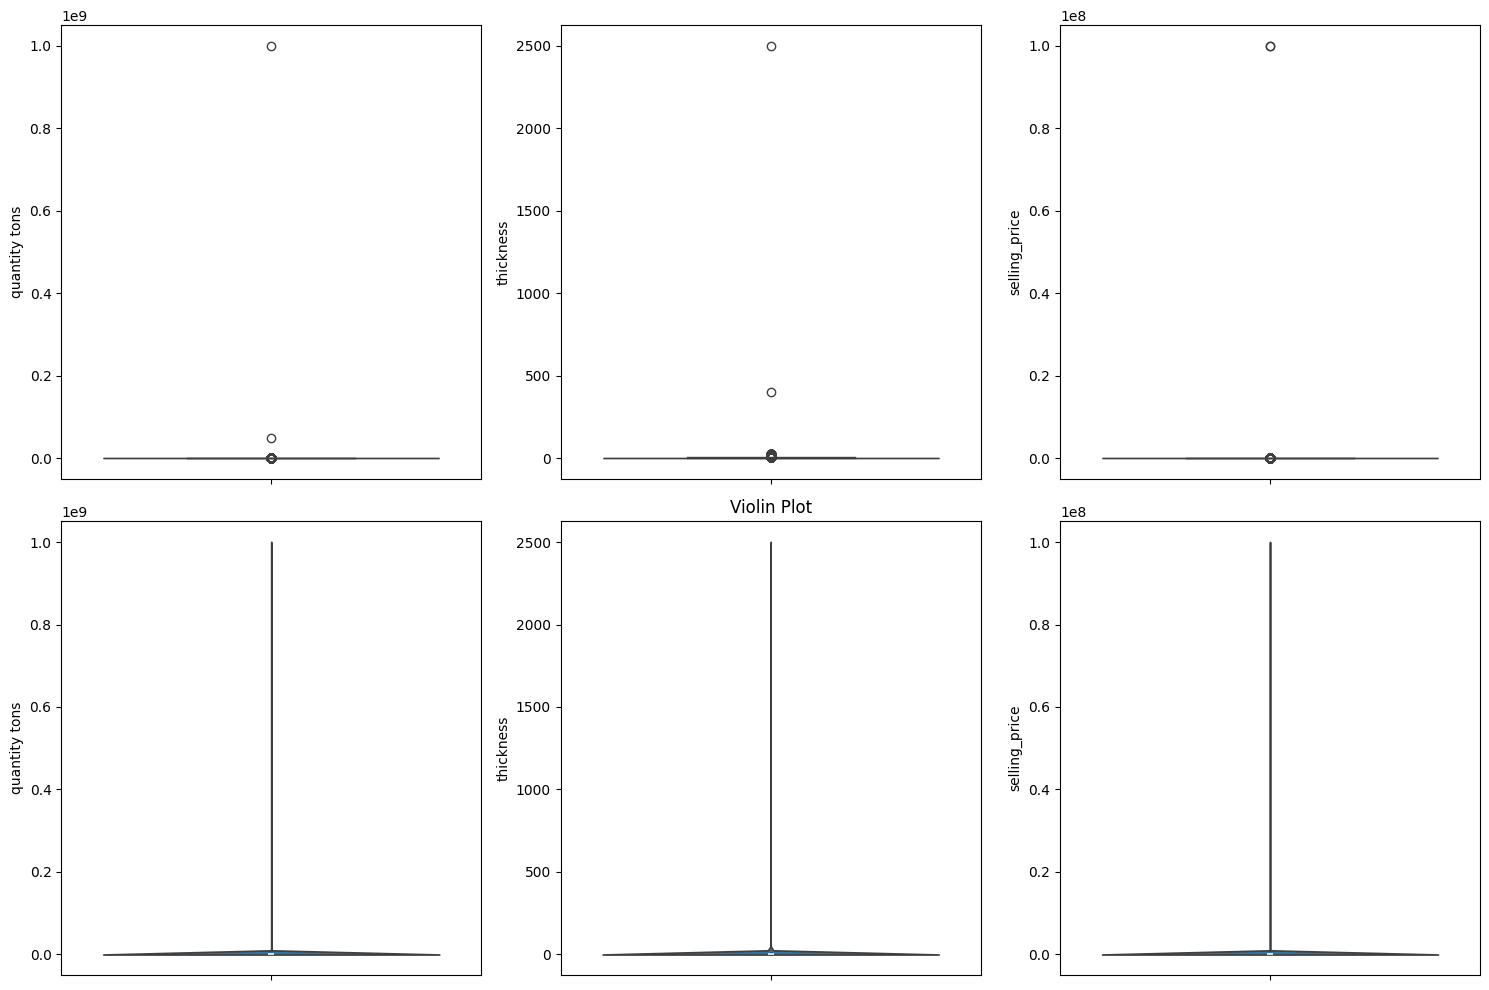

In [ ]:
#Box plot e violin plot
plt.figure(figsize=(15, 10))
plt.title('Box Plot')

plt.subplot(231)
sns.boxplot(df['quantity tons'])

plt.subplot(232)
sns.boxplot(df['thickness'])

plt.subplot(233)
sns.boxplot(df['selling_price'])


plt.subplot(234)
sns.violinplot(df['quantity tons'])

plt.subplot(235)
plt.title('Violin Plot')
sns.violinplot(df['thickness'])

plt.subplot(236)
sns.violinplot(df['selling_price'])

plt.tight_layout()
plt.show()

In [ ]:
# Detecção de Outlier
def outlier_detection(array):
    q1 = np.percentile(array, 25)
    q3 = np.percentile(array, 75)

    iqr = q3 - q1
    threshold = 1.5 * iqr

    lower_bound = q1 - threshold
    upper_bound = q3 + threshold

    # Identify outliers
    outliers = sorted([x for x in array if x < lower_bound or x > upper_bound])

    return outliers

A lista de Outliers é muito longa, portanto não foi apresentada.

In [ ]:
#Outliers

print("Outliers of Quantity:", outlier_detection(df['quantity tons']))
print("Outliers of Thickness:", outlier_detection(df['thickness']))
print("Outliers of Width:", outlier_detection(df['width']))
print("Outliers of Selling price:", outlier_detection(df['selling_price']))

Outliers of Quantity: [-2000.0, 151.4605407, 151.4613152, 151.462929, 151.4692217, 151.4726224, 151.4771474, 151.4776772, 151.4829189, 151.4849619, 151.4884569, 151.4937385, 151.4998722, 151.5024119, 151.5065728, 151.508447, 151.5113128, 151.5115051, 151.5153224, 151.5197033, 151.5203864, 151.5364366, 151.5417235, 151.543996, 151.5451706, 151.5471989, 151.5544845, 151.5587754, 151.5591807, 151.5618291, 151.570507, 151.5709319, 151.5735543, 151.5811404, 151.5836705, 151.583864, 151.5868067, 151.5871716, 151.5887606, 151.5889295, 151.5981704, 151.609525, 151.6249889, 151.6265353, 151.6382169, 151.6387928, 151.6504325, 151.6523033, 151.6585439, 151.6592585, 151.6594086, 151.6650066, 151.6697477, 151.6712774, 151.6716769, 151.6828494, 151.6917496, 151.6956698, 151.7025941, 151.7031465, 151.7056877, 151.7057673, 151.7076112, 151.7112852, 151.7203293, 151.722213, 151.7247199, 151.7248351, 151.7252301, 151.7291722, 151.7293505, 151.7318895, 151.7461568, 151.7601129, 151.7669635, 151.7860304, 

Eliminando os valores negativos encontrados na detecção de outliers usando IQR

In [ ]:
# Tratando valores discrepantes negativos
mask1 = df['quantity tons'] <= 0
print('Negative/Zero quantity values:', mask1.sum())
df.loc[mask1, 'quantity tons'] = np.nan

mask2 = df['selling_price'] <= 0.1
print('Negative/Zero selling price values:',mask2.sum())
df.loc[mask2, 'selling_price'] = np.nan

Negative/Zero quantity values: 4
Negative/Zero selling price values: 8


In [ ]:
# Descartando os valores
df = df.dropna()

In [ ]:
# Replicando o DF e transformando-o
df1 = df.copy()

In [ ]:
# Fazendo transformações logarítmicas
df1['quantity tons_log'] = np.log(df1['quantity tons'])
df1['thickness_log'] = np.log(df1['thickness'])
df1['selling_price_log'] = np.log(df1['selling_price'])

In [ ]:
df1.shape

(181619, 17)

In [ ]:
df1.head(2)

,id,item_date,quantity tons,customer,country,status,item type,application,thickness,width,material_ref,product_ref,delivery date,selling_price,quantity tons_log,thickness_log,selling_price_log
0,EC06F063-9DF0-440C-8764-0B0C05A4F6AE,2021-04-01,54.151139,30156308.0,28.0,Won,W,10.0,2.0,1500.0,DEQ1 S460MC,1670798778,2021-07-01,854.0,3.991779,0.693147,6.749931
1,4E5F4B3D-DDDF-499D-AFDE-A3227EC49425,2021-04-01,768.024839,30202938.0,25.0,Won,W,41.0,0.8,1210.0,unknown,1668701718,2021-04-01,1047.0,6.643822,-0.223144,6.953684


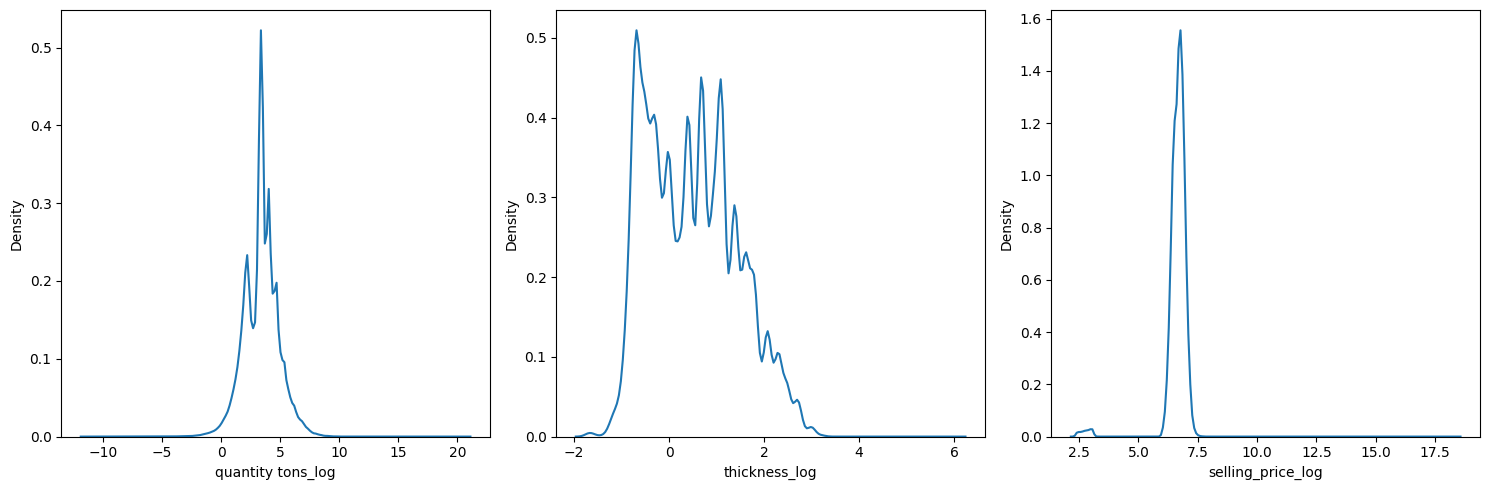

In [ ]:
# Gráficos de densidade do Kernel após a transformação do log
plt.figure(figsize=(15, 5))
plt.title("Kernel Density Plot")

plt.subplot(131)
sns.kdeplot(df1['quantity tons_log'])

plt.subplot(132)
sns.kdeplot(df1['thickness_log'])

plt.subplot(133)
sns.kdeplot(df1['selling_price_log'])

plt.tight_layout()
plt.show()

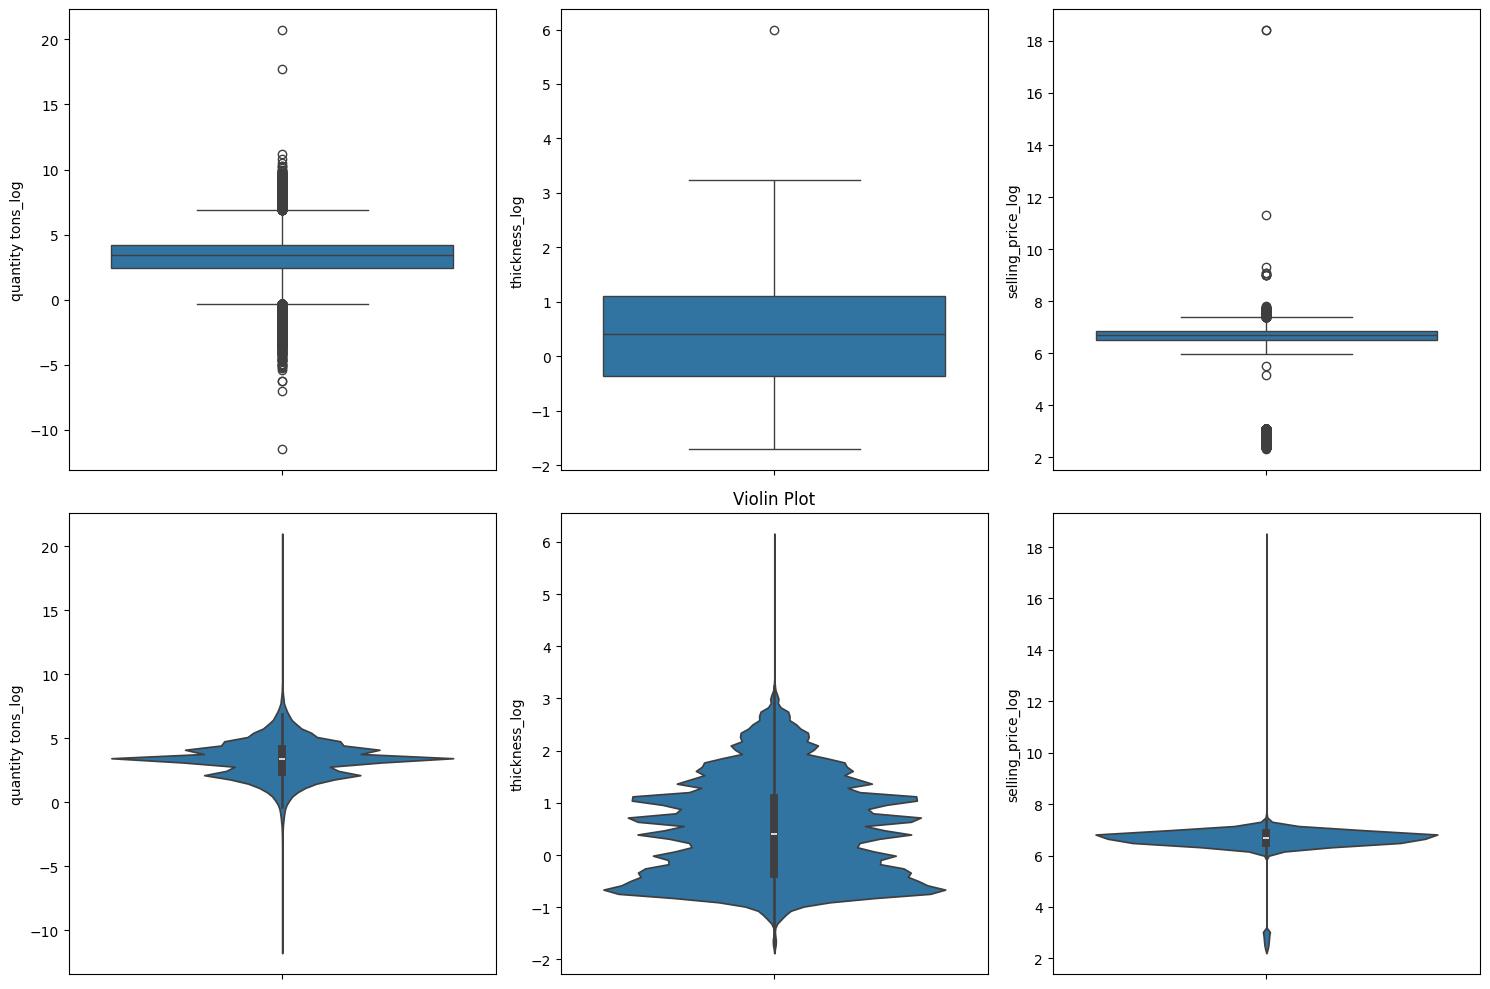

In [ ]:
# Box plot e gráficos de violino após transformação de log
plt.figure(figsize=(15, 10))
plt.title('Box Plot')

plt.subplot(231)
sns.boxplot(df1['quantity tons_log'])

plt.subplot(232)
sns.boxplot(df1['thickness_log'])

plt.subplot(233)
sns.boxplot(df1['selling_price_log'])


plt.subplot(234)
sns.violinplot(df1['quantity tons_log'])

plt.subplot(235)
plt.title('Violin Plot')
sns.violinplot(df1['thickness_log'])

plt.subplot(236)
sns.violinplot(df1['selling_price_log'])

plt.tight_layout()
plt.show()

ANÁLISE MULTIVARIADA

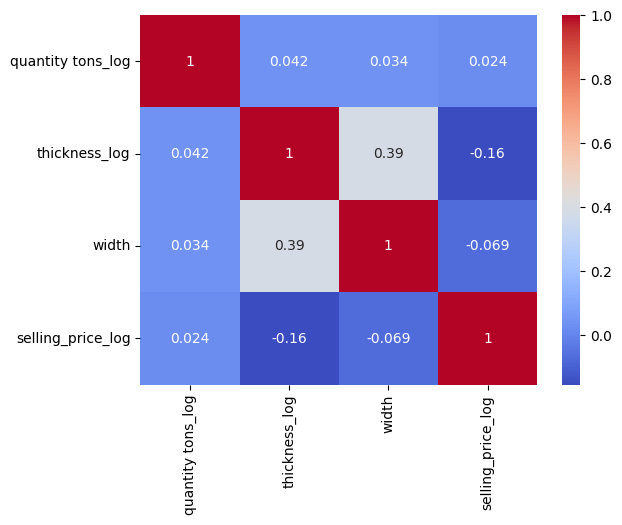

In [ ]:
# Heatmap para recursos de quantidade, espessura, largura e preço de detalhamento após transformações de log
correlation_matrix = df1[['quantity tons_log','thickness_log','width','selling_price_log']].corr()

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

CODIFICAÇÃO DE ITEM_TYPE E COLUNAS DE STATUS

In [ ]:
# Replicando DF para modelo de regressão
df_r  = df1.copy()

In [ ]:
df_r['item type'].unique()

array(['W', 'WI', 'S', 'Others', 'PL', 'IPL', 'SLAWR'], dtype=object)

In [ ]:
df_r.status.unique()

array(['Won', 'Draft', 'To be approved', 'Lost', 'Not lost for AM',
       'Wonderful', 'Revised', 'Offered', 'Offerable'], dtype=object)

In [ ]:
# Rótulo de codificaçãode item tipo coluna
le = LabelEncoder()
encoded_data = le.fit_transform(df_r['item type'])
df_r['item type'] = encoded_data

# Codificação ordinal para coluna de status
ord = OrdinalEncoder(categories = 'auto')
encoded_data_1 = ord.fit_transform(df_r[['status']].values)
df_r[['status']]= encoded_data_1

REGRESSION MODEL - USANDO DECISION TREE

In [ ]:
X=df_r[['quantity tons_log','status','item type','application','thickness_log','width','country','customer','product_ref']]
y=df_r['selling_price_log']

scaler = StandardScaler()
X = scaler.fit_transform(X.values)

# Divisão do treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=10)

dtr = DecisionTreeRegressor()
# hiperparametros
param_grid = {'max_depth': [ 10, 15, 20],
              'min_samples_split': [2, 5, 10],
              'min_samples_leaf': [1, 2, 4],
              'max_features': [None, 'sqrt', 'log2']}

grid_search = GridSearchCV(estimator=dtr, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Best hyperparameters:", grid_search.best_params_)

best_dtr = grid_search.best_estimator_
y_pred_4 = best_dtr.predict(X_test)

# Métricas de avaliaçao
mse = mean_squared_error(y_test, y_pred_4)
r2 = r2_score(y_test, y_pred_4)
print('Mean squared error:', mse)
print('R-squared:', r2)

Best hyperparameters: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 10}
Mean squared error: 0.02442108496783746
R-squared: 0.9291047728348067


In [ ]:
# Salvando o modelo
with open('reg_model.pkl', 'wb') as file:
    pickle.dump(best_dtr, file)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('item_type.pkl', 'wb') as f:
    pickle.dump(le, f)
with open('status.pkl', 'wb') as f:
    pickle.dump(ord, f)

TAREFA DE CLASSIFICAÇÃO PARA PREDIZER O STATUS

In [ ]:
df_c = df1.copy()

In [ ]:
get_index = df_c[(df_c.status != 'Won') & (df.status != 'Lost')].index
df_c = df_c.drop(get_index)

In [ ]:
df_c.shape

(150426, 17)

In [ ]:
# Coluna de tipo de item de codificação de rótulo
le = LabelEncoder()
encoded_data = le.fit_transform(df_c['item type'])
df_c['item type'] = encoded_data

# Codificação ordinal para coluna de status
ord = OrdinalEncoder(categories = 'auto')
encoded_data_1 = ord.fit_transform(df_c[['status']].values)
df_c[['status']]= encoded_data_1

In [ ]:
# Avaliando o desequilíbrio de classe
status_vc = df_c.status.value_counts().tolist()

class_won = (status_vc[0] / sum(status_vc)) * 100
class_lost = (status_vc[1] / sum(status_vc)) * 100
print('Status da portentagem de ganho:',round(class_won,2))
print('Status da porcentagem de perda:',round(class_lost,2))

Status da portentagem de ganho: 77.11
Status da porcentagem de perda: 22.89


Podemos observar claramente o desbalanceamento da classe

In [ ]:
# SMOTE-ENN para reamostrar e equilibrar as classes
from collections import Counter
from imblearn.combine import SMOTEENN

y = df_c['status']
X = df_c[['quantity tons_log','selling_price_log','thickness_log','width','application','item type','country','customer','product_ref']]
print('Formato original do dataset:', dict(Counter(y)))
sme = SMOTEENN(random_state=42)
X_res, y_res = sme.fit_resample(X, y)
print('Formato do conjunto de dados reamostrado:', dict(Counter(y_res)))

Formato original do dataset: {1.0: 115995, 0.0: 34431}
Formato do conjunto de dados reamostrado: {0.0: 98679, 1.0: 97483}


In [ ]:
X = X_res
y = y_res

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

logr = LogisticRegression(solver='saga')

logr_params = {
    'C': [0.1, 1, 10, 100],
    'penalty': ['l1', 'l2']
}

grid_search = GridSearchCV(estimator=logr, param_grid=logr_params, cv = 10, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Melhores hiperparametros:", grid_search.best_params_)
best_logr = grid_search.best_estimator_
y_pred_1 = best_logr.predict(X_test)
y_pred_proba_1 = best_logr.predict_proba(X_test)[:, 1]

Melhores hiperparametros: {'C': 100, 'penalty': 'l1'}


In [ ]:
# Métricas de classificação para regressão logística
accuracy_1 = accuracy_score(y_test, y_pred_1)
precision_1 = precision_score(y_test, y_pred_1)
recall_1 = recall_score(y_test, y_pred_1)
f1_1 = f1_score(y_test, y_pred_1)
fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_pred_proba_1)
roc_auc_1 = roc_auc_score(y_test, y_pred_proba_1)

# Imprima e plote as métricas
print(f"Accuracy: {accuracy_1:.2f}")
print(f"Precision: {precision_1:.2f}")
print(f"Recall: {recall_1:.2f}")
print(f"F1 Score: {f1_1:.2f}")
print(f"AUC: {roc_auc_1:.2f}")

Accuracy: 0.71
Precision: 0.72
Recall: 0.70
F1 Score: 0.71
AUC: 0.77


In [ ]:
y = y_res
X = X_res

scaler = StandardScaler()
X = scaler.fit_transform(X.values)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# decision tree classifier
dtc = DecisionTreeClassifier()

# hyperparameters
dtc_grid = {'max_depth': [ 10, 15, 20],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': [None, 'sqrt', 'log2']}

grid_search = GridSearchCV(estimator=dtc, param_grid=dtc_grid, cv=5)
grid_search.fit(X_train, y_train)
print("Melhores hiperparametros:", grid_search.best_params_)

best_dtc = grid_search.best_estimator_
y_pred_2 = best_dtc.predict(X_test)
y_pred_proba_2 = best_dtc.predict_proba(X_test)[:, 1]

Melhores hiperparametros: {'max_depth': 20, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [ ]:
# Métricas de classificação para DecisionTreeClassifier
accuracy_2 = accuracy_score(y_test, y_pred_2)
precision_2 = precision_score(y_test, y_pred_2)
recall_2 = recall_score(y_test, y_pred_2)
f1_2 = f1_score(y_test, y_pred_2)
fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_pred_proba_2)
roc_auc_2 = roc_auc_score(y_test, y_pred_proba_2)

# Imprima e plote as métricas
print(f"Accuracy: {accuracy_2:.2f}")
print(f"Precision: {precision_2:.2f}")
print(f"Recall: {recall_2:.2f}")
print(f"F1 Score: {f1_2:.2f}")
print(f"AUC: {roc_auc_2:.2f}")

Accuracy: 0.97
Precision: 0.98
Recall: 0.96
F1 Score: 0.97
AUC: 0.98


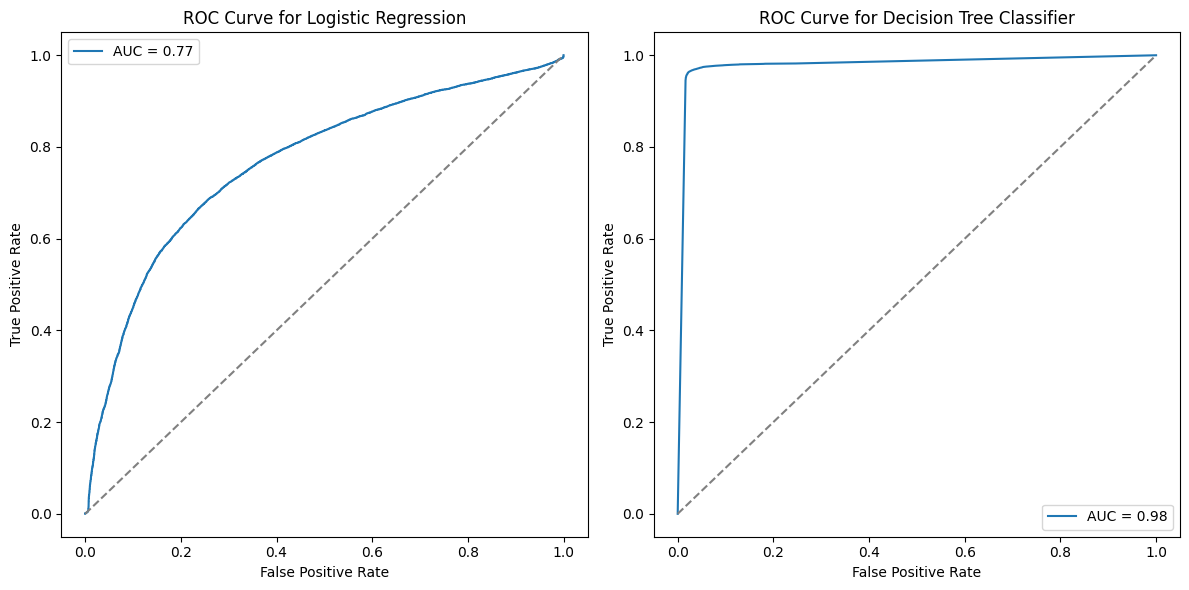

In [ ]:
plt.figure(figsize=(12, 6))

# Traçar curva ROC para regressão logística
plt.subplot(121)
plt.plot(fpr_1, tpr_1, label=f'AUC = {roc_auc_1:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend()

# Traçar curva ROC para classificador de árvore de decisão
plt.subplot(122)
plt.plot(fpr_2, tpr_2, label=f'AUC = {roc_auc_2:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Decision Tree Classifier')
plt.legend()

plt.tight_layout()
plt.show()

O Decision Tree Classifier foi o modelo escolhido por apresentar os melhores resultados

In [ ]:
# O modelo de predição do status é escolhido em base ao valores obtidos
X_new1 = np.array([[np.log(300),np.log(700),np.log(2),800.0,28.0,'S',30.0,30153963.0,628377]])
X_new1[:,[5]]=le.transform(np.ravel(X_new1[:,[5]]))
X_new1 = scaler.transform(X_new1)
y_pred1 = best_dtc.predict(X_new1)
if y_pred1 == 1:
    print("Status: Won")
else:
    print("Status: Lost")
print('Predicted Status:',y_pred1)

Status: Lost
Predicted Status: [0.]


In [ ]:
# Salvando o modelo
with open('clf_model.pkl', 'wb') as file:
    pickle.dump(best_dtc, file)
with open('clf_scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('clf_le.pkl', 'wb') as f:
    pickle.dump(le, f)